In [1]:
import pandas as pd
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from subprocess import call
from skimage import data, io, filters, exposure
from skimage.io import imshow, imread
from skimage.morphology import skeletonize
from skimage.util import invert
from skimage.segmentation import active_contour

In [2]:
#!pip3 install pypotrace

## helpers

In [3]:
def show_cvimg(img):
    if len(img.shape) > 2:
        img2 = img[:,:,::-1]
        plt.imshow(img2)
    else:
        plt.imshow(img, cmap='gray')

### file loading

In [4]:
path = '../data/stylegan'

files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if '.jpg' in file:
            files.append(os.path.join(r, file))


for f in files:
    print(os.path.basename(f))

latent1.jpg
latent2.jpg
sample04.jpg
sample01.jpg
sample02.jpg
sample03.jpg
jasper_lake.jpg
jasper_bear.jpg


In [9]:
fname = files[6]
# fname = files[7]
# fname = files[2]
fname

'../data/stylegan/jasper_encoding/jasper_lake.jpg'

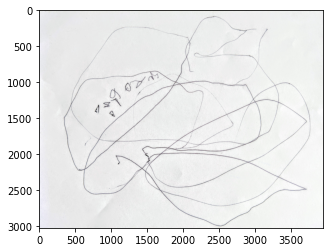

In [10]:
img = cv2.imread(fname)
show_cvimg(img)

### Edged Detection and Histogram Equalization

In [11]:
def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    # from here http://www.pyimagesearch.com/2015/04/06/zero-parameter-automatic-canny-edge-detection-with-python-and-opencv/

    v = np.median(image)
 
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edge = cv2.Canny(image, lower, upper)
 
    # return the edge image
    return edge

In [12]:
# convert to grayscale
gray = np.zeros((img.shape[0], img.shape[1], 1), np.uint8)
edge = np.zeros((img.shape[0], img.shape[1], 1), np.uint8)
blurred = np.zeros((img.shape[0], img.shape[1], 1), np.uint8)

In [13]:
# make greyscale copy of inpnut
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

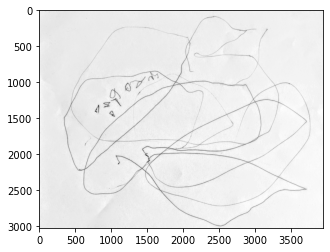

In [14]:
# blur
blurred = cv2.blur(gray, (5,5))
show_cvimg(blurred)

In [15]:
cv2.imwrite("blurred.png", blurred)

True

In [16]:
# # downsample
# newsize = (blurred.shape[1]//3, blurred.shape[0]//3)
# resized = cv2.resize(blurred, newsize, interpolation = cv2.INTER_AREA)

In [17]:
# show_cvimg(resized)

### medial axis

In [18]:
from skimage.morphology import medial_axis

In [19]:
# data = cv2.adaptiveThreshold(blurred,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
#             cv2.THRESH_BINARY,block_size,6)

_, binary = cv2.threshold(blurred, 225, 255, cv2.THRESH_BINARY)
data = invert(binary)

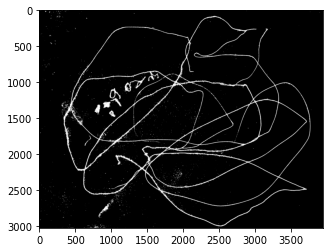

In [20]:
show_cvimg(data)

In [21]:
# Compute the medial axis (skeleton) and the distance transform
skel, distance = medial_axis(data, return_distance=True)

In [22]:
skel

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [23]:
# # im_bw = cv2.fromarray(skel)
# import scipy.misc
# im_bw = scipy.misc.toimage(skel)

skel = skel.astype(np.uint8)  #convert to an unsigned byte
skel*=255

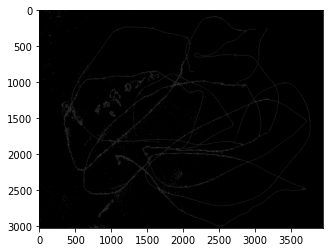

In [24]:
# skel = skel * 255.0
show_cvimg(skel)

In [25]:
cv2.imwrite("medial.png", skel)

True

In [45]:
# contours, hierarchy = cv2.findContours(skel, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# contours, hierarchy = cv2.findContours(data, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours, hierarchy = cv2.findContours(data, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [46]:
# cnt_img = cv2.drawContours(img, contours, -1, (0, 255, 0), 2)
# show_cvimg(cnt_img)

simplify the countours

In [47]:
# cnt = contours[0]
# epsilon = 0.01*cv2.arcLength(cnt,True)
# approx = cv2.approxPolyDP(cnt, epsilon, True)

In [52]:
min_length = 100
epsilon_factor = 0.01#0.0001 #The bigger the fraction, the more sides are chopped off the original polygon

In [53]:
thresh_copy = img.copy()
simple_cnt = []
# print('number of sides per shape:')
for contour in contours:
    perimeter = cv2.arcLength(contour, True)
#     print(perimeter)
    if perimeter > min_length:
#         e = 0.0005*perimeter 
        e = epsilon_factor*perimeter #The bigger the fraction, the more sides are chopped off the original polygon
        contour = cv2.approxPolyDP(contour, epsilon=e, closed=True)
        simple_cnt.append(contour)
#     cv2.drawContours(thresh_copy, [ contour ], contourIdx=-1, color=(0, 255, 0), thickness=2)
#     print('', contour.shape[0])
# show_cvimg(thresh_copy)

True

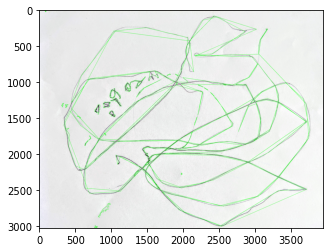

In [54]:
img_copy = img.copy()
img_copy = cv2.drawContours(img_copy, simple_cnt, -1, (0, 255, 0), 2)
# img_copy = cv2.drawContours(img_copy, simple_cnt, -1, (0, 255, 0), 12)
show_cvimg(img_copy)
cv2.imwrite("contour_overlay.png", img_copy)

write to svg file:

In [55]:
w = img.shape[1]
h = img.shape[0]

with open("path.svg", "w+") as f:
    f.write(f'<svg width="{w}" height="{h}" xmlns="http://www.w3.org/2000/svg">')
    
    for c in simple_cnt:
        f.write('<path d="M')
        for i in range(len(c)):
            x, y = c[i][0]
            f.write(f"{x} {y} ")
#         f.write('" style="stroke:pink"/>')
        f.write('" fill="transparent" stroke="blue"/>')
    f.write("</svg>")
f.close()

# simple_cnt

### canny edge detection

In [30]:
edged = auto_canny(blurred, 0.3)
# edged = auto_canny(blurred, 0.9)
# edged = auto_canny(blurred)
# edged = auto_canny(resized)

In [31]:
# edged = cv2.Canny(gray, 50, 200)

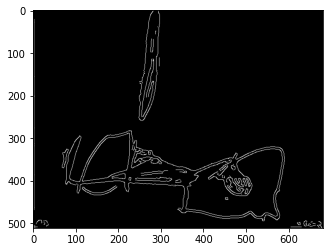

In [32]:
plt.imshow(edged, cmap='gray')

In [33]:
cv2.imwrite("edged.png", edged)

True

adaptive thresholding:

In [34]:
# block_size = 7
# adaptive = cv2.adaptiveThreshold(edged,16,cv2.ADAPTIVE_THRESH_MEAN_C,\
#             cv2.THRESH_BINARY, block_size, 5)
# # data = invert(data)

In [35]:
# plt.imshow(adaptive, cmap='gray')

In [36]:
# cv2.imwrite("adaptive.png", adaptive)

### Find Contours

In [37]:
# _, binary = cv2.threshold(edged, 225, 255, cv2.THRESH_BINARY)
_, binary = cv2.threshold(blurred, 225, 255, cv2.THRESH_BINARY)

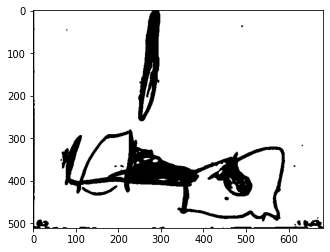

In [38]:
show_cvimg(binary)

In [39]:
cv2.imwrite("binary.png", binary)

True

In [40]:
# contours,hierarchy = cv2.findContours(edge, 1, 2)

# contours, hierarchy = cv2.findContours(binary,  
#     cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 

contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [41]:
# contours

from https://docs.opencv.org/trunk/d4/d73/tutorial_py_contours_begin.html

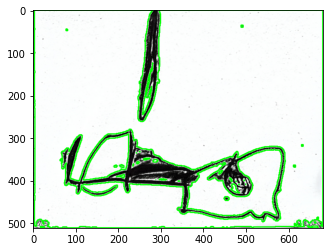

In [42]:
img = cv2.drawContours(img, contours, -1, (0, 255, 0), 2)
show_cvimg(img)

In [248]:
cv2.imwrite("contour_overlay.png", img)

True

In [249]:
# c = max(contours, key=cv2.contourArea) #max contour
# f = open('jasper_bear.svg', 'w+')
# f.write('<svg width="'+str(img.shape[1])+'" height="'+str(img.shape[0])+'" xmlns="http://www.w3.org/2000/svg">')
# f.write('<path d="M')

# for i in range(len(c)):
#     #print(c[i][0])
#     x, y = c[i][0]
#     print(x)
#     f.write(str(x)+  ' ' + str(y)+' ')

# f.write('"/>')
# f.write('</svg>')
# f.close()

In [250]:
w = img.shape[1]
h = img.shape[0]

with open("path.svg", "w+") as f:
    f.write(f'<svg width="{w}" height="{h}" xmlns="http://www.w3.org/2000/svg">')
    
    for c in contours:
        f.write('<path d="M')
        for i in range(len(c)):
            x, y = c[i][0]
            f.write(f"{x} {y} ")
#         f.write('" style="stroke:pink"/>')
        f.write('" fill="transparent" stroke="blue"/>')
    f.write("</svg>")
f.close()

## Sandbox

### Connected components

see https://stackoverflow.com/questions/48356874/create-path-from-opencv-contour

In [104]:
# edged = invert(edged)
# show_cvimg(edge)

In [105]:
# binary = cv2.threshold(edge, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

In [106]:
# show_cvimg(binary)

In [107]:
## Find connected edges
# ret, labels = cv2.connectedComponents(binary)

In [108]:
# print(ret)

In [109]:
# print(labels)

In [110]:
# colors = [(0, 0, 255), (0, 43, 255), (0, 85, 255), (0, 128, 255), (0, 170, 255), (0, 213, 255), (0, 255, 255), (0, 255, 212), (0, 255, 170), (0, 255, 127), (0, 255, 85), (0, 255, 42), (0, 255, 0), (43, 255, 0), (85, 255, 0), (128, 255, 0), (170, 255, 0), (213, 255, 0), (255, 255, 0), (255, 212, 0), (255, 170, 0), (255, 127, 0), (255, 85, 0), (255, 42, 0), (255, 0, 0)]

# ## Draw(set to different colors)
# canvas = np.zeros((edge.shape[0], edge.shape[1], 3), np.uint8)
# for i in range(1,ret):
#     pts = labels == i
#     canvas[pts] = colors[i%len(colors)]

In [111]:
# show_cvimg(canvas)

### skeletonize

In [ ]:
from skimage.morphology import skeletonize
from skimage.util import invert
from skimage.segmentation import active_contour

In [ ]:
block_size = 7

In [ ]:
blurred = cv2.medianBlur(resized, block_size)
# blurred = cv2.medianBlur(gray, block_size)

In [ ]:
show_cvimg(blurred)

In [ ]:
# data = cv2.adaptiveThreshold(blurred,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
#             cv2.THRESH_BINARY,block_size,11)

In [ ]:
data = cv2.adaptiveThreshold(blurred,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,block_size,6)
data = invert(data)

In [ ]:
# ret,data = cv2.threshold(blurred,196,255,cv2.THRESH_BINARY_INV)

In [ ]:
show_cvimg(data)

In [ ]:
# data = invert(data)
data[data == 255] = 1
data.shape

In [ ]:
show_cvimg(data)

In [ ]:
skeleton = skeletonize(data)
skeleton_lee = skeletonize(data, method='lee')

In [ ]:
skeleton.shape

In [ ]:
plt.imshow(skeleton_lee)

In [ ]:
plt.imshow(skeleton)

In [ ]:
# Find contours at a constant value of 0.8
r = skeleton
contours = measure.find_contours(r, 0.8)

In [ ]:
# Display the image and plot all contours found
fig, ax = plt.subplots()
# ax.imshow(r, cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

### tracing image

In [ ]:
potrace = "potrace"
infile = edgefile
width = 8
height = 6
margin = 1
outfile = "traced.svg"
tracecmd = potrace+" {0} -W {1} -H {2} -M {3} -i -a 0 -s -o {4}".format(infile, width, height, margin, outfile)

print(tracecmd)

In [ ]:
call(tracecmd)

### histogram and morphological expand

In [ ]:
filename = "../data/stylegan/jasper_encoding/jasper_bear.jpg"

In [ ]:
#scikitimage
# image = imread(filename)

# img_adapteq = exposure.equalize_adapthist(image, clip_limit=0.03)
# imshow(img_adapteq, cmap='gray')
# imshow(image, cmap='gray')

In [ ]:
img = cv2.imread(fname)
show_cvimg(img)

In [ ]:
# make greyscale copy of input
gray = np.zeros((img.shape[0], img.shape[1], 1), np.uint8)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [ ]:
block_size = 11

In [ ]:
blurred = cv2.medianBlur(gray, block_size)

In [ ]:
show_cvimg(blurred)

In [ ]:
data = cv2.adaptiveThreshold(blurred,16,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,block_size,6)
data = invert(data)

In [ ]:
show_cvimg(data)

In [ ]:
edge = np.zeros((img.shape[0], img.shape[1], 1), np.uint8)
blurred = np.zeros((img.shape[0], img.shape[1], 1), np.uint8)

In [ ]:
# blur
blurred = cv2.blur(gray, (7,7))
show_cvimg(blurred)

### Notes

- https://www.pyimagesearch.com/2019/03/04/holistically-nested-edge-detection-with-opencv-and-deep-learning/